In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *
import random

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")


Using GPU


# Hyperparameters

In [2]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-01-01")
train_start_date = pd.to_datetime("2020-01-01")
out_cols = ['pct_change']
outdims = len(out_cols)
epochs = 10
batch_size = 128
d_model = 64 # number of input features to encoder layer
nhead = 8 # number of heads in multiheadattention
num_layers = 8 # number of encoder layers
dropout = 0.1 # dropout probability
learning_rate = 0.0001

# loading data
data_path = 'data'
interval = '1d'
companies = os.listdir(data_path)
# companies = ['AAPL' ]
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

companies = random.sample(companies, 5)

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)

# Loading Data

In [4]:
def load_data(
    companies: list[str],
    ids: np.array,
    data_path: str,
    interval: str,
    train_start_date: pd.Timestamp,
    test_start_date: pd.Timestamp,
    out_cols: list[str],
    seq_size: int,
):
    """
    Function to load data from csv files in company folders

    Inputs
        companies: list of company tickers for data to be loaded
        ids: array of floats for each company ticker
        data_path: path where comapany folders are located
        interval: frequency of stock price data (1d, 1h, etc)
        train_start_date: first date to include in training data
        test_start_date: first test date to include in testing data
        out_cols: names of columns that the model will predict
        seq_size: number of datapoints in each sequence before prediction

    Outputs
        train_loader: training set dataloader for model
        test_loader: test set dataloader for model
        indims: number of input dimensions for model
        outdims: number of output dimensions for model
        dates: test set prediction dates
        company_stats: dictionary where the keys are the ticker and values are that company's stat dict (see z_norm documentation)
        num_to_ticker: dictionary where the keys are the unique number from ids and values are respective ticker
        ticker_to_num: dictionary where the keys are the company ticker and the values are the unique number for that ticker
        feature_cols_idx: index of output feature columns for use in training (since number of columns in y must be equal to number of columns in x in TensorDataset)
    """

    company_stats = dict()  # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    x_train = []
    x_test = []
    y_train = []
    y_test = []
    dates = []

    for co in tqdm(companies):
        files = os.listdir(os.path.join(data_path, co))
        for f in files:  # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df["date"] = pd.to_datetime(df["date"])
        # remove blank column
        df = df.drop(columns=["Unnamed: 0"])
        # remove data before training start date
        df = df[df["date"] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, ["date", 'pct_change'])
        # add ticker column
        df_normed["ticker"] = ticker_to_num[co]

        # get index of test start date
        test_start_idx = np.min(np.argmax(df_normed["date"] >= test_start_date))

        # get dates for test data
        pred_dates = df_normed["date"].iloc[test_start_idx + seq_size :].tolist()
        dates.append(pred_dates)

        # drop date column before making sequences
        df_normed = df_normed.drop(columns=["date"])

        # store column indices for extracting output features we want
        feature_cols_idx = [
            list(df_normed.columns).index(feature) for feature in out_cols
        ]

        # convert to 2D numpy array of shape (-1, num_cols)
        data_arr = df_normed.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, data_arr)
        for i in range(len(x)):
            if i < test_start_idx - seq_size:
                x_train.append(x[i])
                y_train.append(y[i])
            else:
                x_test.append(x[i])
                y_test.append(y[i])

        company_stats[co] = stat_dict

    indims = y_train[0].shape[0]
    outdims = len(out_cols)
    dates = [element for nestedlist in dates for element in nestedlist]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
    y_test = np.vstack(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return (
        train_loader,
        test_loader,
        indims,
        outdims,
        dates,
        company_stats,
        num_to_ticker,
        ticker_to_num,
        feature_cols_idx,
    )
# (
#     train_loader,
#     test_loader,
#     indims,
#     outdims,
#     dates,
#     company_stats,
#     num_to_ticker,
#     ticker_to_num,
#     feature_cols_idx,
# ) = load_data(
#     companies,
#     ids,
#     data_path,
#     interval,
#     train_start_date,
#     test_start_date,
#     out_cols,
#     seq_size,
# )


In [3]:
def load_from_files(
    companies: list[str],
    ids: np.array,
    data_path: str,
    interval: str,
    train_start_date: pd.Timestamp,
    test_start_date: pd.Timestamp,
):
    company_stats = dict()  # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    df_list = []
    test_start_idx = dict()

    for co in companies:
        files = os.listdir(os.path.join(data_path, co))
        for f in files:  # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df["date"] = pd.to_datetime(df["date"])
        # remove blank column
        df = df.drop(columns=["Unnamed: 0"])
        # remove data before training start date
        df = df[df["date"] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, ["date", 'pct_change'])
        company_stats[co] = stat_dict
        # add ticker column
        df_normed["ticker"] = ticker_to_num[co]
        df_list.append(df_normed)

        # get index of test start date
        test_start_idx[co] = np.min(np.argmax(df_normed["date"] >= test_start_date))

    return df_list, test_start_idx, company_stats, num_to_ticker, ticker_to_num


def recreate_dataloaders(df_list: list[pd.DataFrame], seq_size: int, test_idx: dict, test_idx_offset: int):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    test_dates = dict() # should all be the same?

    for j, df_normed in enumerate(df_list):
        # save test date for respective company
        test_dates[companies[j]] = df_normed['date'].iloc[test_idx[companies[j]] + test_idx_offset]

        # drop date column before making sequences
        df_normed = df_normed.drop(columns=["date"])

        # store column indices for extracting output features we want
        feature_cols_idx = [
            list(df_normed.columns).index(feature) for feature in out_cols
        ]

        # convert to 2D numpy array of shape (-1, num_cols)
        data_arr = df_normed.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, data_arr)
        for i in range(len(x)):
            if i < test_idx[companies[j]] + test_idx_offset - seq_size:
                x_train.append(x[i])
                y_train.append(y[i])
            elif i == test_idx[companies[j]] + test_idx_offset - seq_size:
                x_test.append(x[i])
                y_test.append(y[i])


    indims = y_train[0].shape[0]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.array(x_test).reshape(-1, seq_size, indims)
    y_test = np.array(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, test_loader, indims, test_dates, feature_cols_idx



In [4]:
df_list, test_start_idx, company_stats, num_to_ticker, ticker_to_num = load_from_files(companies, ids, data_path, interval, train_start_date, test_start_date)
train_loader, test_loader, indims, test_dates, feature_cols_idx = recreate_dataloaders(df_list, seq_size, test_start_idx, test_idx_offset=0)

# Transformer models
Using basic transformer from https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [5]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=512, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
            )
        self.decoder.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.1
            torch.nn.init.zeros_(m.bias)
            torch.nn.init.uniform_(m.weight, -initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x
    

# Positional Encoding for Transformer (batch first)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class BigTransformer(nn.Module):
    def __init__(self, indim, outdim, hidden_dim=256, d_model=64, nhead=4, num_encoder_layers=6, num_decoder_layers=6):
        super(BigTransformer, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model)
        self.embedding = nn.Sequential(
            nn.Linear(indim, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
            )
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, batch_first=True)

        self.decoder_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, outdim)
        )

        self.d_model = d_model

    # src: (B, S, F) batches, sequence length, features
    # tgt: (B, F)
    def forward(self, src, tgt):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt.unsqueeze(1))
        tgt = self.pos_encoder(tgt)
        src_mask = nn.Transformer.generate_square_subsequent_mask(src.shape[1]).to(device)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        out = self.transformer(src, tgt, src_mask, tgt_mask, src_is_causal=True, tgt_is_causal=True)
        out = self.decoder_mlp(out)
        return out.squeeze(1)
    
    def generate(self, src, max_len=100, start_token=None, end_token=None):
        device = src.device
        src = self.embedding(src)
        src = self.pos_encoder(src)
        src_mask = nn.Transformer.generate_square_subsequent_mask(src.shape[1]).to(device)

        output_seq = torch.zeros((src.shape[0], 1, self.d_model)).to(device)
        if start_token is not None:
            output_seq[:, 0] = self.embedding(start_token.to(device))

        for i in range(max_len):
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(output_seq.shape[1]).to(device)
            next_token = self.transformer(src, output_seq, src_mask=src_mask, tgt_mask=tgt_mask)
            output_seq = torch.cat([output_seq, next_token], dim=1)

            if end_token is not None and torch.all(next_token == end_token):
                break
            
        output_seq = self.decoder_mlp(output_seq[:, 1:]) # exclude start token
        
        return output_seq.squeeze(1)



# shape of input data is going to be [batch_size, seq_size, indims]
# model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
model = BigTransformer(indims, outdims, 256, d_model, nhead, num_encoder_layers=6, num_decoder_layers=6).to(device)

# training loop with BCE Logits Loss (sigmoid) and testing one day at a time
since y_batch will be pct_change for prediction day, I set any pct_change <= 0 to 0, and pct_change > 0 to 1, meaning an increase in price is denoted by a 1 and decrease is denoted by a 0

In [6]:
# Train the model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(model, criterion, optimizer, train_loader, test_loader, device, num_to_ticker, feature_cols_idx, test_dates, out_cols):
    early_stop_count = 0
    min_val_loss = float('inf')

    results = []
    gt_preds = []

    for d in range(50):
        # train a lot in the beginning, then only do a few epochs for fine tuning
        epochs = 20 if d == 0 else 10
        for epoch in range(epochs):
            model.train()
            train_losses = []
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(x_batch, y_batch)
                y_batch = y_batch[:, feature_cols_idx]
                y_batch[y_batch <= 0] = 0
                y_batch[y_batch > 0] = 1
                loss = criterion(outputs, y_batch)
                loss.backward()
                train_losses.append(loss.item())
                optimizer.step()

            # Validation
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch in test_loader:
                    x_batch, y_batch = batch
                    y_batch = y_batch[:, feature_cols_idx]
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    outputs = model.generate(x_batch, max_len=1)
                    
                    y_batch[y_batch <= 0] = 0
                    y_batch[y_batch > 0] = 1
                    loss = criterion(outputs, y_batch)
                    val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            train_loss = np.mean(train_losses)
            
            print(f"Test day {d+1} Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # record test measurement
        with torch.no_grad():
            for batch in test_loader:
                x_batch, y_batch = batch
                tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
                y_batch = y_batch[:, feature_cols_idx]
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model.generate(x_batch, max_len=1)

                gt_outputs = process_results_incremental(y_batch, test_dates, tickers)
                processed_outputs = process_results_incremental(torch.sigmoid(outputs), test_dates, tickers)
                [results.append(out) for out in processed_outputs]
                [gt_preds.append(out) for out in gt_outputs]

        train_loader, test_loader, indims, test_dates, feature_cols_idx = recreate_dataloaders(df_list, seq_size, test_start_idx, test_idx_offset=d + 1)

    columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
    df_pred = pd.DataFrame(results, columns=columns)
    df_gt = pd.DataFrame(gt_preds, columns=columns)
    df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
    df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
    df_merged = pd.merge(df_pred, df_gt, 'inner')

    return model, df_merged

model, df_merged = train_loop(model, criterion, optimizer, train_loader, test_loader, device, num_to_ticker, feature_cols_idx, test_dates, out_cols)
df_merged.head()

c:\Users\oraga\anaconda3\envs\stocks\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Test day 1 Epoch 1/20, Train Loss: 0.6953, Validation Loss: 0.6897
Test day 1 Epoch 2/20, Train Loss: 0.6950, Validation Loss: 0.6792
Test day 1 Epoch 3/20, Train Loss: 0.6943, Validation Loss: 0.6803
Test day 1 Epoch 4/20, Train Loss: 0.6938, Validation Loss: 0.6980
Test day 1 Epoch 5/20, Train Loss: 0.6940, Validation Loss: 0.6890
Test day 1 Epoch 6/20, Train Loss: 0.6940, Validation Loss: 0.6971
Test day 1 Epoch 7/20, Train Loss: 0.6939, Validation Loss: 0.6871
Test day 1 Epoch 8/20, Train Loss: 0.6931, Validation Loss: 0.6965
Test day 1 Epoch 9/20, Train Loss: 0.6844, Validation Loss: 0.7052
Test day 1 Epoch 10/20, Train Loss: 0.6617, Validation Loss: 0.6784
Test day 1 Epoch 11/20, Train Loss: 0.6385, Validation Loss: 0.7024
Test day 1 Epoch 12/20, Train Loss: 0.6254, Validation Loss: 0.6891
Test day 1 Epoch 13/20, Train Loss: 0.6079, Validation Loss: 0.7948
Test day 1 Epoch 14/20, Train Loss: 0.6080, Validation Loss: 0.6960
Test day 1 Epoch 15/20, Train Loss: 0.5928, Validation Lo

,pct_change_pred,ticker,date,pct_change_gt
0,0.621032,VFC,2023-01-03,0.004708
1,0.614945,BA,2023-01-03,0.025723
2,0.710243,ILMN,2023-01-03,-0.006578
3,0.623435,GIS,2023-01-03,-0.007513
4,0.664182,WM,2023-01-03,0.000956


In [ ]:
saved_weights_path = 'saved_models'
fn = f'AAPL_model_{datetime.now().strftime("%Y%m%d")}.pt'

In [ ]:
torch.save(model.state_dict(), os.path.join(saved_weights_path, fn))

# Testing

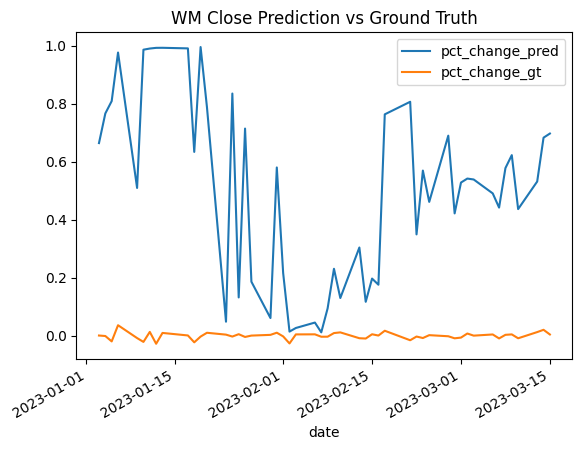

In [7]:
co = companies[4]
df_merged[df_merged['ticker'] == co].plot(x='date', y=['pct_change_pred', 'pct_change_gt'])
plt.legend()
plt.title(f"{co} Close Prediction vs Ground Truth")
plt.show()

In [8]:
accuracy_metrics = dict()
for i in tqdm(range(len(companies))):
    gt_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_gt"]
    pred_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_pred"]
    accuracy_metrics[companies[i]] = directional_accuracy_prob(gt_rows, pred_rows)

100%|██████████| 5/5 [00:00<00:00, 833.10it/s]


In [9]:
accuracy_metrics

{'VFC': 0.24, 'BA': 0.26, 'ILMN': 0.26, 'GIS': 0.32, 'WM': 0.3}

In [10]:
directional_accuracy_prob(df_merged['pct_change_gt'], df_merged['pct_change_pred'])


0.276